In [9]:
import pandas as pd
import numpy as np
from glob import glob
from scipy import stats
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes
import json
import random
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
from transformer_lens import HookedTransformer
import torch
from jaxtyping import Float, Int
from collections import defaultdict
from sklearn.decomposition import TruncatedSVD
import itertools
import torch.nn.functional as F
import math
import seaborn as sns

## Setup

In [159]:
def get_device_str() -> str:
    if torch.backends.mps.is_available():
        return "mps"
    else:
        return "cuda" if torch.cuda.is_available() else "cpu"


def comp_js_divergence(
    p_logit: Float[torch.Tensor, "*batch vocab"],
    q_logit: Float[torch.Tensor, "*batch vocab"],
) -> Float[torch.Tensor, "*batch"]:
    p_logprob = torch.log_softmax(p_logit, dim=-1)
    q_logprob = torch.log_softmax(q_logit, dim=-1)
    p = p_logprob.exp()
    q = q_logprob.exp()

    # convert to log2
    p_logprob *= math.log2(math.e)
    q_logprob *= math.log2(math.e)

    m = 0.5 * (p + q)
    m_logprob = m.log2()

    p_kl_div = (p * (p_logprob - m_logprob)).sum(-1)
    q_kl_div = (q * (q_logprob - m_logprob)).sum(-1)

    assert p_kl_div.isfinite().all()
    assert q_kl_div.isfinite().all()
    return (p_kl_div + q_kl_div) / 2


def find_js_dist_blowup_max_slope(
    js_dists: List[float], min_slope_threshold: float = 0.02
):
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    if not any(np.array(slopes) > min_slope_threshold):
        return len(steps) - 1

    return np.argsort(np.nan_to_num(slopes))[::-1][0]


def find_js_dist_blowup(
    js_dists: List[float],
    slope_threshold: float = 1.25,
    min_js_distance: float = 0.1,
    min_slope_threshold: float = 0.02,
) -> int:
    steps = list(range(len(js_dists)))

    slopes = []
    for i in range(1, len(steps)):
        dy = js_dists[i] - js_dists[i - 1]
        dx = steps[i] - steps[i - 1]
        slopes.append(dy / dx if dx != 0 else 0)

    # Pad the beginning of slopes list to match the length of steps
    slopes = [slopes[0]] + slopes

    for i in range(1, len(steps)):
        current_slope = slopes[i]
        prev_slope = slopes[i - 1]

        # print(f"step={i}, {current_slope=} {prev_slope=}, {slope_threshold * max(prev_slope, 1e-6)}")

        # Check if we're in an increasing trend and above minimum JS distance
        if (
            current_slope > (slope_threshold * max(prev_slope, 1e-6))
            or current_slope >= min_slope_threshold
        ) and js_dists[i] >= min_js_distance:
            return i

    return len(steps) - 1


def find_plateau_length_js(
    js_dists: List[float], threshold: float = 5e-03, window_size: int = 5
) -> int:

    def calculate_slope(y_values, x_values):
        slope, _, _, _, _ = stats.linregress(x_values, y_values)
        return slope

    for i in range(len(js_dists) - window_size + 1):
        window = js_dists[i : i + window_size]
        x_values = list(range(window_size))
        slope = calculate_slope(window, x_values)

        if abs(slope) > threshold:
            return i

    return len(js_dists) - 1


def load_jsonl(file_path):
    data = []
    with open(file_path, "r") as file:
        for line in file:
            # Parse each line as a JSON object
            json_object = json.loads(line.strip())
            data.append(json_object)
    return data


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act


def plot_heatmap_feature_acts(feature_activations, js_dists):
    # Assuming feature_activations is a PyTorch tensor
    feature_acts_np = (
        feature_activations.numpy()
    )  # Convert to numpy if it's not already

    # Identify top features from start and end
    n_top = 10
    start_top_features = np.argsort(feature_acts_np[0])[-n_top:][::-1]
    end_top_features = np.argsort(feature_acts_np[-1])[-n_top:][::-1]

    # Assume js_blowup_step is the time step where JS distance starts increasing rapidly
    js_blowup_step = find_js_dist_blowup(js_dists)  # Replace with your actual step

    # Combine and get unique features
    combined_features = np.unique(
        np.concatenate([start_top_features, end_top_features])
    )

    # Create labels for y-axis
    y_labels = []

    feature_ranks = []

    for feat in combined_features:
        start_rank = np.where(start_top_features == feat)[0]
        end_rank = np.where(end_top_features == feat)[0]
        feature_rank = 0

        label = f"F{feat}"
        if len(start_rank) > 0:
            label += f" (S-{start_rank[0]+1})"
            feature_rank += start_rank[0]
        else:
            feature_rank += n_top

        if len(end_rank) > 0:
            label += f" (E-{end_rank[0]+1})"
            if len(start_rank) == 0:
                feature_rank += 10 + end_rank[0]

        y_labels.append(label)
        feature_ranks.append(feature_rank)

    sorted_feature_ranks = np.argsort(feature_ranks)
    sorted_y_labels = [y_labels[idx] for idx in sorted_feature_ranks]

    # Create heatmap
    fig, ax = plt.subplots(figsize=(20, len(combined_features) / 2 + 2))
    sns.heatmap(
        feature_acts_np[:, combined_features[sorted_feature_ranks]].T,
        cmap="coolwarm",
        cbar_kws={"label": "Activation"},
        yticklabels=sorted_y_labels,
        ax=ax,
    )

    # Add vertical line for JS distance blowup
    ax.axvline(x=js_blowup_step, color="white", linestyle="--", linewidth=2)

    # Add text annotation for the JS blowup line
    ax.text(
        js_blowup_step,
        len(combined_features) - 0.25,
        "JS Dist Blowup",
        rotation=90,
        va="bottom",
        ha="right",
        color="white",
        fontweight="normal",
    )

    # Assuming js_distances is your array of JS distances over time
    ax2 = ax.twinx()
    ax2.plot(js_dists, color="white", linewidth=2)
    ax2.set_ylabel("JS Distance", color="white")
    ax2.tick_params(axis="y", labelcolor="white")

    plt.title("Top Feature Activations Over Time (Start and End)")
    plt.xlabel("Time Steps")
    plt.ylabel("Feature ID (Start Rank, End Rank)")
    plt.tight_layout()
    plt.show()

In [3]:
model = HookedTransformer.from_pretrained("gpt2")
device = get_device_str()

print(device)

Loaded pretrained model gpt2 into HookedTransformer
cuda


In [4]:
perturbation_layer = "blocks.0.hook_resid_pre"
saes, sparsities = get_gpt2_res_jb_saes(perturbation_layer)
sae = saes[perturbation_layer].cpu()
feature_sparsities = 10 ** sparsities[perturbation_layer].cpu()

sae.eval()

100%|██████████| 1/1 [00:00<00:00,  1.30it/s]


SAE(
  (activation_fn): ReLU()
  (hook_sae_input): HookPoint()
  (hook_sae_acts_pre): HookPoint()
  (hook_sae_acts_post): HookPoint()
  (hook_sae_output): HookPoint()
  (hook_sae_recons): HookPoint()
  (hook_sae_error): HookPoint()
)

## Load & Clean data

In [11]:
metadata, activations = [], []

n_files = 10

for path in sorted(glob("observations/metadata*"))[:n_files]:
    metadata.extend(load_jsonl(path))

for path in sorted(glob("observations/acts*"))[:n_files]:
    activations.append(np.load(path))

activations = np.concatenate(activations)

In [12]:
len(metadata), activations.shape

(10000, (10000, 100, 768))

In [18]:
# Clean data
clean_metadata = []
clean_activations = []

n_examples = 10_000
idxs = random.sample(range(len(metadata)), n_examples)

max_recon_error = 3.0
c = 0

for idx in idxs:
    m = metadata[idx]
    acts = activations[idx]
    js_dists = [s["js_dist"] for s in m["steps_metadata"]]

    if js_dists[-1] - js_dists[0] < 0.1:
        continue

    if np.isnan(js_dists).sum() > 1:
        continue

    blowup_point = find_js_dist_blowup_max_slope(js_dists)

    if blowup_point >= len(js_dists) - 1:
        continue

    act_recon = sae.decode(sae.encode(torch.tensor(acts[0])))
    recon_error = torch.tensor(acts[0]) - act_recon
    recon_error = recon_error.abs().sum(dim=-1).detach().numpy()

    if recon_error > max_recon_error:
        continue

    clean_metadata.append(m)
    clean_activations.append(acts)

    c += 1

    if c % 1000 == 0:
        print(c)

clean_activations = np.stack(clean_activations)

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500


In [19]:
len(clean_metadata), clean_activations.shape

(6769, (6769, 100, 768))

In [20]:
metadata = clean_metadata
activations = clean_activations

## Prediction Function

In [21]:
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import entropy

In [22]:
def find_crossover_point(feature_acts):
    start_feature = feature_acts[:, 0]
    end_feature = feature_acts[:, 1]

    # Compare absolute values
    mask = torch.abs(end_feature) > torch.abs(start_feature)

    # Find the first True value in the mask
    crossover_indices = torch.nonzero(mask)

    if crossover_indices.numel() > 0:
        return crossover_indices[0].item()
    else:
        return feature_acts.shape[0] // 2


def extract_crossover_point(feature_acts):
    top_features_start = torch.argsort(feature_acts[0])[-5:].flip(dims=(0,))
    top_features_end = torch.argsort(feature_acts[-1])[-5:].flip(dims=(0,))
    feature_ids = [top_features_start[0].item(), top_features_end[0].item()]
    crossover_point = find_crossover_point(feature_acts[:, feature_ids])
    return crossover_point


def get_data_for_step(steps):
    step_js_dists = [s["js_dist"] for s in steps]
    js_blowup_step = find_js_dist_blowup_max_slope(step_js_dists)
    sensitivity = 1 - js_blowup_step / len(step_js_dists)
    feature_acts = get_feature_activations(steps)
    return feature_acts, step_js_dists, js_blowup_step, sensitivity


def get_feature_activations(steps):
    feature_activations = []
    for _, s in enumerate(steps):
        active_feature_ids = s["active_feature_ids"]
        active_feature_acts = s["active_feature_acts"]
        feature_acts = torch.zeros(sae.W_enc.shape[1])
        feature_acts[active_feature_ids] = torch.tensor(active_feature_acts)
        feature_activations.append(feature_acts)
    return torch.stack(feature_activations)


def find_crossover_point_between_vectors(v1, v2):
    for i, (n1, n2) in enumerate(zip(v1, v2)):
        if n1 < n2:
            return i
    return len(v1)


def get_feature_dir(sae, feature_id, feature_act, norm=False):
    feature_acts = torch.zeros(sae.W_enc.shape[1])

    # Activate the specified feature
    feature_acts[:] = 0
    feature_acts[feature_id] = feature_act

    # Decode back to the residual stream space
    perturbed_act = sae.decode(feature_acts)

    if norm:
        perturbed_act /= torch.norm(perturbed_act)

    return perturbed_act

## Modelling

In [327]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from scipy.stats import entropy
import cupy as cp
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from scipy.stats import entropy
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from scipy.signal import find_peaks

In [398]:
import numpy as np
from scipy.fft import fft
from scipy.stats import skew, kurtosis
from sklearn.decomposition import PCA
from scipy.signal import find_peaks


def extract_advanced_activation_features(feature_acts):
    _, n_features = feature_acts.shape
    feature_acts = feature_acts.numpy()
    features = []

    for feat in range(n_features):
        sequence = feature_acts[:, feat]

        # 1. Frequency domain analysis
        fft_vals = np.abs(fft(sequence))
        dominant_freq = np.argmax(fft_vals[1:]) + 1  # Exclude DC component
        freq_magnitude = np.max(fft_vals[1:])  # Magnitude of dominant frequency

        # 2. Activation trajectory
        start_val = sequence[0]
        end_val = sequence[-1]
        max_val = np.max(sequence)
        min_val = np.min(sequence)
        range_val = max_val - min_val

        # 3. Statistical moments
        mean_val = np.mean(sequence)
        std_val = np.std(sequence)
        skewness = skew(sequence)
        kurt = kurtosis(sequence)

        # 4. Peaks and valleys analysis
        peaks, _ = find_peaks(sequence)
        valleys, _ = find_peaks(-sequence)
        n_peaks = len(peaks)
        n_valleys = len(valleys)
        peak_valley_ratio = n_peaks / n_valleys if n_valleys != 0 else n_peaks

        # 5. Activation speed
        activation_speed = np.mean(np.abs(np.diff(sequence)))

        # 6. Threshold crossing
        threshold = (max_val + min_val) / 2
        crossings = np.sum(np.diff((sequence > threshold).astype(int)) != 0)

        features.extend(
            [
                dominant_freq,
                freq_magnitude,
                start_val,
                end_val,
                max_val,
                min_val,
                range_val,
                mean_val,
                std_val,
                skewness,
                kurt,
                n_peaks,
                n_valleys,
                peak_valley_ratio,
                activation_speed,
                crossings,
            ]
        )

    # 7. Cross-feature analysis
    corr_matrix = np.corrcoef(feature_acts.T)
    mean_correlation = np.mean(np.abs(corr_matrix[np.triu_indices(n_features, k=1)]))

    # 9. Activation space volume
    volume = np.prod(np.max(feature_acts, axis=0) - np.min(feature_acts, axis=0))

    features.extend([mean_correlation, volume])

    return features


def construct_features_and_label(steps, acts):
    feature_acts, step_js_dists, js_blowup_step, sensitivity = get_data_for_step(steps)
    n_steps = len(steps)

    # Find crossover point
    cp_point = extract_crossover_point(feature_acts)
    pred_sensitivity_cp = 1 - cp_point / len(steps)

    # Find top features start relevant info
    top_feature_ids_start = torch.argsort(feature_acts[0]).numpy()[::-1][:3].tolist()
    top_feature_acts_start = feature_acts[:, top_feature_ids_start]
    top_feature_acts_norm_start = (
        top_feature_acts_start / top_feature_acts_start.max(dim=0).values
    )
    top_feature_acts_start_mean = top_feature_acts_norm_start.mean(dim=-1)

    top_features_acts_start_slopes = (
        ((top_feature_acts_norm_start[-1] - top_feature_acts_norm_start[0]) / n_steps)
        .numpy()
        .tolist()
    )
    top_feature_acts_start_mean_slope = (
        (top_feature_acts_start_mean[-1] - top_feature_acts_start_mean[0]) / n_steps
    ).item()

    # Find top features end relevant info
    top_feature_ids_end = torch.argsort(feature_acts[-1]).numpy()[::-1][:3].tolist()
    top_feature_acts_end = feature_acts[:, top_feature_ids_end]
    top_feature_acts_norm_end = (
        top_feature_acts_end / top_feature_acts_end.max(dim=0).values
    )
    top_feature_acts_end_mean = top_feature_acts_norm_end.mean(dim=-1)

    top_features_acts_end_slopes = (
        ((top_feature_acts_norm_end[-1] - top_feature_acts_norm_end[0]) / n_steps)
        .numpy()
        .tolist()
    )
    top_feature_acts_end_mean_slope = (
        (top_feature_acts_end_mean[-1] - top_feature_acts_end_mean[0]) / n_steps
    ).item()

    # Crossover point between feature acts mean
    cp_point_mean_feats = find_crossover_point_between_vectors(
        top_feature_acts_start_mean, top_feature_acts_end_mean
    )

    # Feature dirs cosine
    start_act = torch.tensor(acts[0]).unsqueeze(0)
    end_act = torch.tensor(acts[-1]).unsqueeze(0)

    top_feature_dirs_start = torch.stack(
        [
            get_feature_dir(sae, fid, feature_acts[0, fid].item(), norm=False)
            for fid in top_feature_ids_start
        ]
    )
    top_feature_dirs_end = torch.stack(
        [
            get_feature_dir(sae, fid, feature_acts[-1, fid].item(), norm=False)
            for fid in top_feature_ids_end
        ]
    )

    # Cosine similarity between top features from A with A
    top_features_a_a_sim = (
        torch.cosine_similarity(start_act, top_feature_dirs_start)
        .detach()
        .numpy()
        .tolist()
    )

    # Cosine similarity between top features from A with T
    top_features_a_t_sim = (
        torch.cosine_similarity(end_act, top_feature_dirs_start)
        .detach()
        .numpy()
        .tolist()
    )

    # Cosine similarity between top features from T with A
    top_features_t_a_sim = (
        torch.cosine_similarity(start_act, top_feature_dirs_end)
        .detach()
        .numpy()
        .tolist()
    )

    # Cosine similarity between top features from T with T
    top_features_t_t_sim = (
        torch.cosine_similarity(end_act, top_feature_dirs_end).detach().numpy().tolist()
    )

    # Cosine sim between top feature in A with top features in T
    top_feature1_start_t_sim = torch.cosine_similarity(
        top_feature_dirs_start[0, :], top_feature_dirs_end
    ).tolist()

    # Cosine sim between top feature in A with top features in T
    top_feature2_start_t_sim = torch.cosine_similarity(
        top_feature_dirs_start[1, :], top_feature_dirs_end
    ).tolist()

    # Cosine sim between top feature in A with top features in T
    top_feature3_start_t_sim = torch.cosine_similarity(
        top_feature_dirs_start[2, :], top_feature_dirs_end
    ).tolist()

    features = [
        pred_sensitivity_cp,
        *top_features_acts_start_slopes,
        top_feature_acts_start_mean_slope,
        *top_features_acts_end_slopes,
        top_feature_acts_end_mean_slope,
        cp_point_mean_feats,
        *top_features_a_a_sim,
        *top_features_a_t_sim,
        *top_features_t_a_sim,
        *top_features_t_t_sim,
        *top_feature1_start_t_sim,
        *top_feature2_start_t_sim,
        *top_feature3_start_t_sim,
    ]

    # Reintroduce gradient and acceleration features
    row_indices = np.arange(feature_acts.shape[0])[:, np.newaxis]
    top_features_per_step = np.argsort(feature_acts)[:, -5:]
    top_features_acts = feature_acts[row_indices, top_features_per_step]

    gradients = np.gradient(top_features_acts, axis=0)
    accelerations = np.gradient(gradients, axis=0)

    max_gradient = np.max(np.abs(gradients), axis=1)
    pred_step_grad = np.argsort(max_gradient)[::-1][0]
    pred_sensitivity_grad = 1 - pred_step_grad / len(steps)

    # Calculate mean and max of gradients and accelerations
    mean_gradient = np.mean(np.abs(gradients))
    max_acceleration = np.max(np.abs(accelerations))
    mean_acceleration = np.mean(np.abs(accelerations))

    # L2 norm calculations
    perturbation = acts[-1] - acts[0]
    l2_norm_perturbation = np.linalg.norm(perturbation)
    l2_norm_start = np.linalg.norm(acts[0])
    l2_norm_end = np.linalg.norm(acts[-1])

    # Ratio of perturbation to starting activation
    l2_norm_ratio_start = (
        l2_norm_perturbation / l2_norm_start if l2_norm_start != 0 else 0
    )

    # Ratio of perturbation to ending activation
    l2_norm_ratio_end = l2_norm_perturbation / l2_norm_end if l2_norm_end != 0 else 0

    # Add new features to the list
    new_features = [
        pred_sensitivity_grad,
        mean_gradient,
        max_acceleration,
        mean_acceleration,
        l2_norm_perturbation,
        l2_norm_ratio_start,
        l2_norm_ratio_end,
    ]

    features.extend(new_features)

    adv_features = extract_advanced_activation_features(top_features_acts)

    features.extend(adv_features)

    return features, sensitivity, step_js_dists, js_blowup_step

In [297]:
# steps = metadata[0]["steps_metadata"]
# acts = activations[0]
# features, label = construct_features_and_label(steps, acts)
# len(features), label

In [400]:
adv_feature_name_templates = [
    "dominant_freq",
    "freq_magnitude",
    "start_val",
    "end_val",
    "max_val",
    "min_val",
    "mean_val",
    "range_val",
    "std_val",
    "skewness",
    "kurt",
    "n_peaks",
    "n_valleys",
    "peak_valley_ratio",
    "activation_speed",
    "crossings",
]

adv_feature_names = [
    *[f"{name}_{i}" for i in range(1, 6) for name in adv_feature_name_templates],
    "mean_corr",
    "volume",
]

feature_names = [
    "crossover_point_sens",
    "top_1_feat_start_slope",
    "top_2_feat_start_slope",
    "top_3_feat_start_slope",
    "top_feats_start_mean_slope",
    "top_1_feat_end_slope",
    "top_2_feat_end_slope",
    "top_3_feat_end_slope",
    "top_feats_end_mean_slope",
    "crossover_point_mean_feat_acts",
    "top_1_feat_start_sim_a",
    "top_2_feat_start_sim_a",
    "top_3_feat_start_sim_a",
    "top_1_feat_start_sim_t",
    "top_2_feat_start_sim_t",
    "top_3_feat_start_sim_t",
    "top_1_feat_end_sim_a",
    "top_2_feat_end_sim_a",
    "top_3_feat_end_sim_a",
    "top_1_feat_end_sim_t",
    "top_2_feat_end_sim_t",
    "top_3_feat_end_sim_t",
    "top_1_feat_start_sim_top_1_feat_end",
    "top_1_feat_start_sim_top_2_feat_end",
    "top_1_feat_start_sim_top_3_feat_end",
    "top_2_feat_start_sim_top_1_feat_end",
    "top_2_feat_start_sim_top_2_feat_end",
    "top_2_feat_start_sim_top_3_feat_end",
    "top_3_feat_start_sim_top_1_feat_end",
    "top_3_feat_start_sim_top_2_feat_end",
    "top_3_feat_start_sim_top_3_feat_end",
    "pred_sensitivity_grad",
    "mean_gradient",
    "max_acceleration",
    "mean_acceleration",
    "l2_norm_perturbation",
    "l2_norm_ratio_start",
    "l2_norm_ratio_end",
    *adv_feature_names,
]

len(feature_names)

120

In [401]:
n_examples = 6769
idxs = random.sample(range(len(metadata)), n_examples)

features, labels = [], []
js_dists, js_blowup_steps = [], []

for idx in idxs:
    steps = metadata[idx]["steps_metadata"]
    acts = activations[idx]
    pert_features, pert_label, pert_js_dists, pert_js_blowup_step = (
        construct_features_and_label(steps, acts)
    )
    features.append(pert_features)
    # labels.append(pert_label)
    labels.append(pert_js_blowup_step)
    js_dists.append(pert_js_dists)
    js_blowup_steps.append(pert_js_blowup_step)

In [404]:
# pd.DataFrame(features, columns=feature_names) # .to_feather("data/dataset.feather")

In [405]:
X = np.array(features)
y = np.array(labels)

In [407]:
indices = np.arange(X.shape[0])

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(
    X, y, indices, test_size=0.2, random_state=113, shuffle=True
)

print(X_train.shape, X_test.shape)

(5415, 120) (1354, 120)


In [408]:
# Convert your data to GPU
X_train_gpu = cp.array(X_train)
y_train_gpu = cp.array(y_train)

In [416]:
reg_model = xgb.XGBRegressor(
    n_estimators=1000,
    max_depth=6,
    learning_rate=0.01,
    min_child_weight=5,
    subsample=0.5,
    reg_alpha=0.2,
    reg_lambda=0.78,
    gamma=0.7,
    random_state=460456,
    device="cuda",
)

In [417]:
y_pred = [50] * len(y_test)
mse = mean_absolute_error(y_test, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_test, y_pred, multioutput="raw_values")[0]

print(f"Baseline MAE: {mse:.4f}")
print(f"Baseline R-squared: {r2:.4f}")

Baseline MAE: 4.9948
Baseline R-squared: -0.1068


In [418]:
reg_model.fit(X_train_gpu, y_train_gpu)

y_pred = reg_model.predict(X_train_gpu)
mse = mean_absolute_error(y_train, y_pred, multioutput="raw_values")[0]
r2 = r2_score(y_train, y_pred, multioutput="raw_values")[0]

print(f"Train MAE: {mse:.4f}")
print(f"Train R-squared: {r2:.4f}")

Train MAE: 2.2222
Train R-squared: 0.7652


In [420]:
# X_test_selected = selector.transform(X_test)
X_test_gpu = cp.array(X_test)
y_pred_test = reg_model.predict(X_test_gpu)

mse = mean_absolute_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print(f"MAE: {mse:.4f}")
print(f"R-squared: {r2:.4f}")

MAE: 3.4779
R-squared: 0.3854


In [421]:
preds = np.concatenate([y_pred, y_pred_test])
preds.shape

(6769,)

In [422]:
# Get feature importance
importance = reg_model.feature_importances_

fn_with_imp = sorted(list(zip(feature_names, importance)), key=lambda t: t[1])[::-1]

# Print feature importance
for fn, v in fn_with_imp[:10]:
    print(f"Feature {fn}: {v:.3f}")

Feature top_3_feat_start_sim_t: 0.092
Feature top_3_feat_end_sim_a: 0.032
Feature top_2_feat_start_sim_a: 0.028
Feature start_val_5: 0.022
Feature top_1_feat_start_sim_a: 0.014
Feature n_valleys_3: 0.012
Feature n_valleys_4: 0.012
Feature range_val_5: 0.012
Feature start_val_1: 0.011
Feature top_3_feat_start_sim_a: 0.011


## Exploring predictions

In [130]:
diffs = np.abs(np.array(y_test) - np.array(y_pred_test))

# diffs = np.abs(np.array(labels) - np.array(preds))
min_diff_idxs = np.argsort(-diffs).tolist()[-10:][::-1]
max_diff_idxs = np.argsort(diffs).tolist()[-10:][::-1]
max_diffs = diffs[max_diff_idxs]
min_diffs = diffs[min_diff_idxs]

In [180]:
random_diff_idxs = random.sample(range(len(diffs)), 10)

In [185]:
idx = random_diff_idxs[1]
original_idx = indices_test[idx]

step_js_dists = js_dists[original_idx]
js_blowup_step = js_blowup_steps[original_idx]
pred = y_pred_test[idx]

abs(pred - js_blowup_step)

5.8189849853515625

In [209]:
pred_df = pd.DataFrame(
    [{"pred": y_pred_test[i], "label": y_test[i]} for i in range(len(y_test))]
)

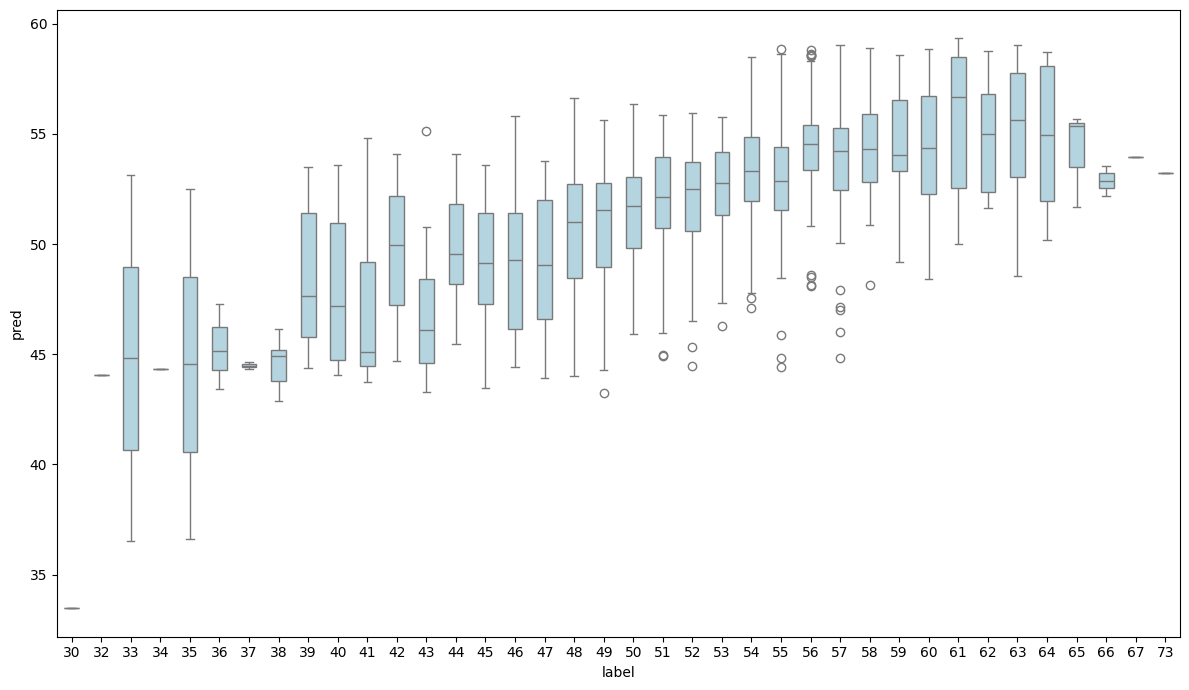

In [210]:
plt.figure(figsize=(12, 7))
sns.boxplot(x="label", y="pred", data=pred_df, color="lightblue", width=0.5)

plt.tight_layout()
plt.show()

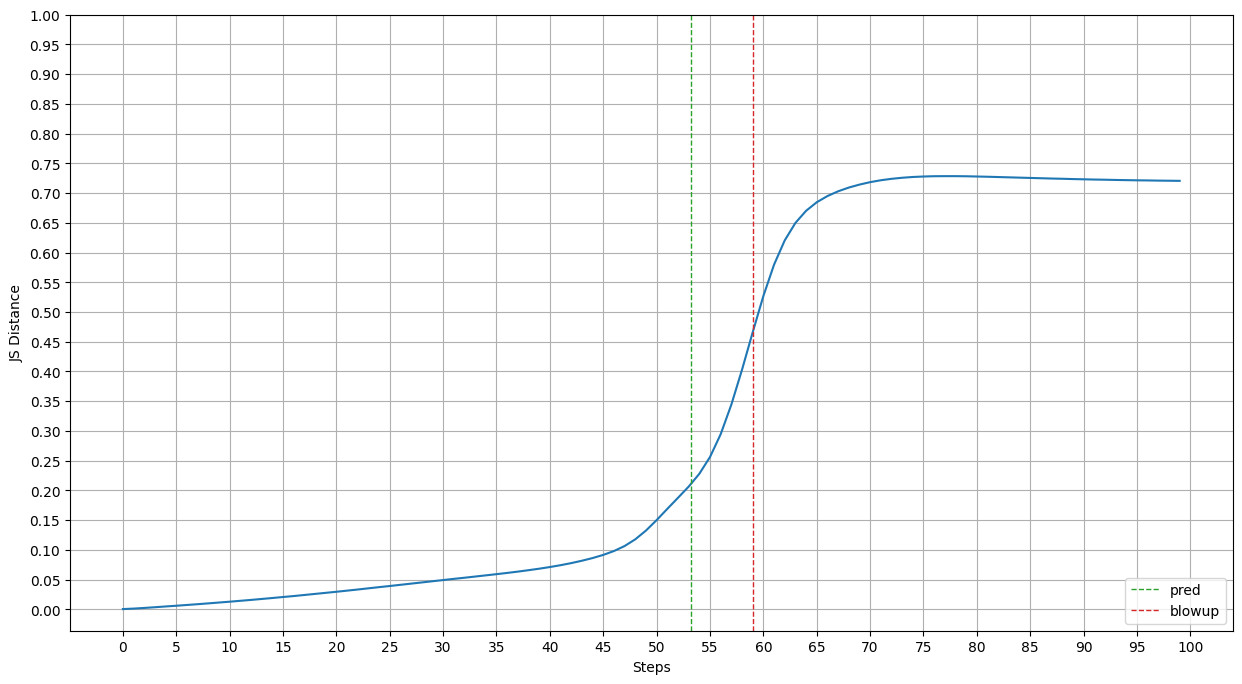

In [211]:
plt.figure(figsize=(15, 8))
plt.plot(step_js_dists)
plt.axvline(x=pred, color="tab:green", linestyle="--", linewidth=1, label="pred")

plt.axvline(
    x=js_blowup_step, color="tab:red", linestyle="--", linewidth=1, label="blowup"
)

plt.yticks(np.arange(0, 1.05, 0.05))
plt.xticks(np.arange(0, 105, 5))
plt.xlabel("Steps")
plt.ylabel("JS Distance")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [ ]:
# plot_heatmap_feature_acts(feature_acts, step_js_dists)

## Optimise Model

In [55]:
import optuna
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
import cupy as cp
import random

In [68]:
def objective(trial, X, y, n_folds=5):
    params = {
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 1.0),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 5),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        # 'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.5, 1.0),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 1.0),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 1.0),
    }

    model = XGBRegressor(**params, device="cuda", random_state=42)

    # Convert CuPy arrays to NumPy for sklearn compatibility
    X_np = cp.asnumpy(X) if isinstance(X, cp.ndarray) else X
    y_np = cp.asnumpy(y) if isinstance(y, cp.ndarray) else y

    # Perform cross-validation
    scores = cross_val_score(
        model, X_np, y_np, cv=n_folds, scoring="neg_mean_squared_error"
    )
    return -scores.mean()  # Return negative MSE for minimization


def optimize_xgboost(X, y, n_trials=100, n_folds=5):
    study = optuna.create_study(direction="minimize")
    study.optimize(lambda trial: objective(trial, X, y, n_folds), n_trials=n_trials)

    best_params = study.best_params
    best_score = -study.best_value

    print("Best parameters found:")
    for key, value in best_params.items():
        print(f"    {key}: {value}")
    print(f"Best cross-validation MSE: {best_score:.4f}")

    # Train the final model with the best parameters
    best_model = XGBRegressor(**best_params, device="cuda", random_state=42)

    # Convert CuPy arrays to NumPy for final fitting
    X_np = cp.asnumpy(X) if isinstance(X, cp.ndarray) else X
    y_np = cp.asnumpy(y) if isinstance(y, cp.ndarray) else y

    best_model.fit(X_np, y_np)

    return best_model, best_params, best_score

In [66]:
sample_idxs = random.sample(range(X.shape[0]), 1000)
X_sample = X[sample_idxs]
y_sample = y[sample_idxs]

In [69]:
best_model, best_params, best_score = optimize_xgboost(X_sample, y_sample, n_trials=100)

# To make predictions (assuming X_test is your test data)
X_test_np = cp.asnumpy(X_test) if isinstance(X_test, cp.ndarray) else X_test
y_pred = best_model.predict(X_test_np)

# Evaluate on test set
mse = mean_squared_error(y_test, y_pred)
print(f"Test MSE: {mse:.4f}")

[I 2024-08-13 21:42:17,107] A new study created in memory with name: no-name-f92f632f-111d-431e-9445-aa70ce93170f
[I 2024-08-13 21:42:20,198] Trial 0 finished with value: 47.89097405694122 and parameters: {'max_depth': 5, 'learning_rate': 0.9138755095155152, 'n_estimators': 647, 'min_child_weight': 3, 'subsample': 0.7356303939960191, 'gamma': 0.5869021980899037, 'reg_alpha': 0.19240918674636312, 'reg_lambda': 0.6607794699923992}. Best is trial 0 with value: 47.89097405694122.
[I 2024-08-13 21:42:20,781] Trial 1 finished with value: 28.252701445334775 and parameters: {'max_depth': 1, 'learning_rate': 0.4639075490076031, 'n_estimators': 329, 'min_child_weight': 3, 'subsample': 0.6020977386064515, 'gamma': 0.37988800596250893, 'reg_alpha': 0.059715330160210425, 'reg_lambda': 0.10968200459462024}. Best is trial 1 with value: 28.252701445334775.
[I 2024-08-13 21:42:25,245] Trial 2 finished with value: 30.34344147881712 and parameters: {'max_depth': 8, 'learning_rate': 0.4207071072614939, 'n

Best parameters found:
    max_depth: 2
    learning_rate: 0.016999397686573485
    n_estimators: 755
    min_child_weight: 5
    subsample: 0.5317797272115067
    gamma: 0.7078385362152435
    reg_alpha: 0.1931275318075108
    reg_lambda: 0.7834273806164702
Best cross-validation MSE: -23.3392
Test MSE: 25.6950
